# FRAUD CLASSIFICATION FROM CUSTOMER / TRANSACTION DATA
## V2 using XGBoost
**Objective** is to build a model to predict fraudulent online transactions on the basis of information about the customer and the circumstances of the transaction. Fraud costs around 2% of all online revenues, and the prevention of fraud is a major and evolving task in data science.<br><br> Two data files are provided: one with customer information and one with transaction information. They are linked by the customer's email address.

**Contents:**
1. [Exploratory data analysis](#s1)
2. [Feature engineering](#s2)
3. [Feature selection](#s3)
3. [Model building](#s4)
4. [Model evaluation](#s5)
5. [Conclusions](#s6)

In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [297]:
cust = pd.read_csv("Customer_DF.csv",index_col=0)
trans = pd.read_csv("cust_transaction_details.csv",index_col=0)

## 1. Exploratory data analysis<a id='s1'></a>

### 1.1 Customer file
#### Overview

In [298]:
cust.head()

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",5,3,2,False
3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM...",3,3,1,False
4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,...",7,7,6,True


In [299]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 167
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   customerEmail           168 non-null    object
 1   customerPhone           168 non-null    object
 2   customerDevice          168 non-null    object
 3   customerIPAddress       168 non-null    object
 4   customerBillingAddress  168 non-null    object
 5   No_Transactions         168 non-null    int64 
 6   No_Orders               168 non-null    int64 
 7   No_Payments             168 non-null    int64 
 8   Fraud                   168 non-null    bool  
dtypes: bool(1), int64(3), object(5)
memory usage: 12.0+ KB


#### Balance of classification: imbalanced but not excessively

In [300]:
print(f"Mean fraud level: {cust['Fraud'].mean():.3f}")

Mean fraud level: 0.363


#### Descriptive features (Email, Phone, Device, IPAddress, BillingAddress):

In [301]:
cust.select_dtypes('object').nunique()

customerEmail             161
customerPhone             168
customerDevice            168
customerIPAddress         165
customerBillingAddress    166
dtype: int64

#### How can these feature be used?
* Email can possibly be used by extracting domain.
* Phone will be of no use. Porting of numbers makes it extremely difficult to pin down whether the number is fixed, contract mobile or pay as you go. International dialling codes are not uniformly included in the field. 
* Device ID will also be of no use - cannot be matched to IMEI format
* IP address could be used to extract country of transaction
* Billing address of no use

#### Numeric features (No_Transactions, No_Orders, No_Payments)

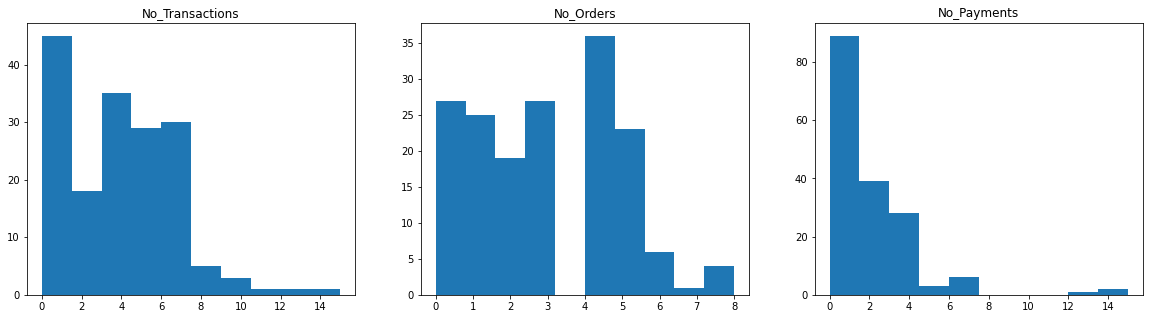

In [302]:
num_cust = cust.select_dtypes("int64")
n = len(num_cust.columns)
fig, axs = plt.subplots(1, n, figsize=(20, 5))
i=0
for col in num_cust.columns:
    axs[i].hist(num_cust[col])
    axs[i].set_title(col)
    i = i+1

All well-behaved

### 1.2 Transaction file
#### Overview

In [303]:
trans.head()

,customerEmail,transactionId,orderId,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,transactionAmount,transactionFailed,orderState
0,josephhoward@yahoo.com,a9lcj51r,vjbdvd,wt07xm68b,1,card,JCB 16 digit,18,0,pending
1,josephhoward@yahoo.com,y4wcv03i,yp6x27,wt07xm68b,1,card,JCB 16 digit,26,0,fulfilled
2,evansjeffery@yahoo.com,5mi94sfw,nlghpa,41ug157xz,0,bitcoin,American Express,45,0,fulfilled
3,evansjeffery@yahoo.com,br8ba1nu,uw0eeb,41ug157xz,0,bitcoin,American Express,23,0,fulfilled
4,evansjeffery@yahoo.com,a33145ss,bn44oh,y3xp697jx,1,bitcoin,VISA 16 digit,43,1,fulfilled


In [304]:
# Convert paymentMethodRegistrationFailure	and transactionFailed to Boolean
trans['paymentMethodRegistrationFailure'] = trans['paymentMethodRegistrationFailure']==1
trans['transactionFailed'] = trans['transactionFailed']==1

In [305]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   customerEmail                     623 non-null    object
 1   transactionId                     623 non-null    object
 2   orderId                           623 non-null    object
 3   paymentMethodId                   623 non-null    object
 4   paymentMethodRegistrationFailure  623 non-null    bool  
 5   paymentMethodType                 623 non-null    object
 6   paymentMethodProvider             623 non-null    object
 7   transactionAmount                 623 non-null    int64 
 8   transactionFailed                 623 non-null    bool  
 9   orderState                        623 non-null    object
dtypes: bool(2), int64(1), object(7)
memory usage: 45.0+ KB


#### Descriptive features

In [306]:
trans.select_dtypes("object").nunique()

customerEmail            136
transactionId            623
orderId                  478
paymentMethodId          237
paymentMethodType          4
paymentMethodProvider     10
orderState                 3
dtype: int64

#### How can these features be used?
* customerEmail is link to cust file.
* The three ..Id features are system specific and uninformative
* paymentMethodType, paymentMethodProvider and orderState are all potentially useful.

#### Numeric feature

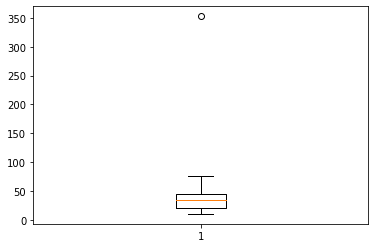

In [307]:
plot = plt.boxplot(trans['transactionAmount'])

In [308]:
# There is an outlier! Remove it
print(f"No of outliers: {sum(trans['transactionAmount'] > 100)}")
trans = trans.loc[trans['transactionAmount'] <= 100]

No of outliers: 1


## 2. Feature engineering<a id='s2'></a>
Following the exploratory data analysis, the following tasks will be completed to engineer the required data set.<br>
Cust:<br> 
1. Join datasets on unique email
1. Extract domain from email address column and group low frequency domains as "other"
5. Extract country field from IPAddress and group low frequency countries as "other"
7. Keep all four numeric columns
6. Drop Billing, customer phone, device, IPAddress, email address, Id columns
7. Convert categorical variables to one-hot encoding

In [309]:
# Join datasets on unique email
cust.drop_duplicates(subset='customerEmail', keep='first', inplace=True)
fraudData = trans.merge(cust, how='left', on='customerEmail')
#
# Extract domain from email address column and group low frequency domains as "other"
fraudData['domain'] = [add.split('@')[1] for add in fraudData['customerEmail']]
domlist = fraudData.groupby(by='domain').size().sort_values(ascending=False).head(5).index.tolist()
fraudData.loc[[d not in domlist for d in fraudData['domain']], 'domain'] = 'Other-domain'
#
# Extract country field from IPAddress and group low frequency countries as "other" 
ipcountry= pd.read_csv("ipcountry.csv")[['IP','Country']].rename(columns={'IP': 'customerIPAddress'})
fraudData = fraudData.merge(ipcountry, how='left', on='customerIPAddress')
countrylist = fraudData.groupby(by='Country').size().sort_values(ascending=False).head(5).index.tolist()
fraudData.loc[[c not in countrylist for c in fraudData['Country']], 'Country'] = 'Other-country'
#
# Drop Billing, customer phone, device, IPAddress, email address, Id columns
fraudData.drop(['customerEmail', 'transactionId', 'orderId', 'paymentMethodId',
       'customerPhone', 'customerDevice', 'customerIPAddress',
       'customerBillingAddress'], axis=1, inplace=True)
#
# Convert Booleans to integer
for col in fraudData.select_dtypes("bool"): fraudData[col] = fraudData[col]*1
#
# Convert categorical variables to one-hot encoded
for col in fraudData.select_dtypes("object"): 
    fraudData = pd.concat([fraudData,pd.get_dummies(fraudData[col],drop_first=False)],axis=1)
    fraudData.drop(col, axis=1, inplace=True)

## 3. Feature selection<a id='s3'></a>

#### Test-train split

In [313]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fraudData.drop('Fraud',axis=1), 
                fraudData['Fraud'], test_size=0.30, random_state=101,stratify=None)

#### Chi-squared test on categorical features

<AxesSubplot:>

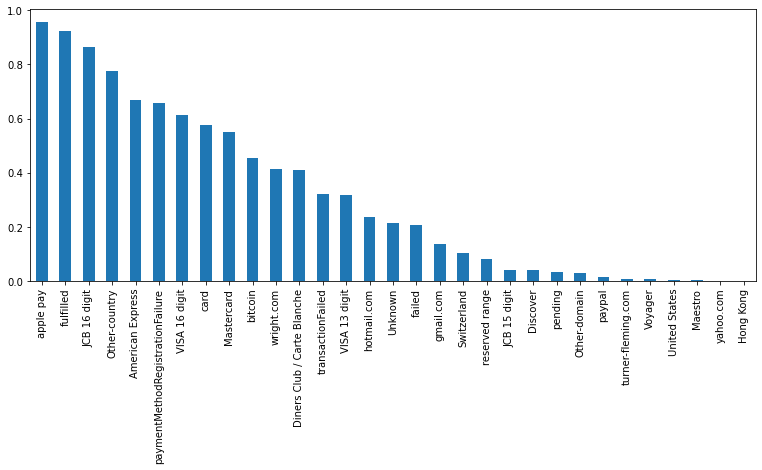

In [314]:
from sklearn.feature_selection import chi2
cat_features = X_train.drop(["transactionAmount","No_Transactions","No_Orders","No_Payments"],axis=1)
chi_scores = chi2(cat_features,y_train)
p_values = pd.Series(chi_scores[1],index = cat_features.columns)
p_values.sort_values(ascending = False , inplace = True)
plt.rcParams['figure.figsize'] = [13, 5]
p_values.plot.bar()

#### Drop features with p-value greater than 0.2

In [315]:
X_train.drop(p_values[p_values > 0.2].index.tolist(),axis=1,inplace=True)
X_test.drop(p_values[p_values > 0.2].index.tolist(),axis=1,inplace=True)
print(f'Features retained = {len(X_train.columns)}')

Features retained = 18


In [316]:
print(f'Incidence of fraud in train set is {np.mean(y_train):.3}')

Incidence of fraud in train set is 0.48


## 4. Model building<a id='s4'></a>
Normalise the data

In [317]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Load XGBoost model and examine a range of hyperparameters:

In [325]:
from sklearn.model_selection import GridSearchCV 
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic', eval_metric = 'aucpr')

test_params = {
    'max_depth':[4,6,8,10,12],
    'n_estimators': [10,20,40,60,80],
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
model.fit(X_train,y_train)
print (f'Model = {model.best_params_}')
print(f'Score = {model.best_score_:.3}')

Model = {'colsample_bytree': 1.0, 'learning_rate': 0.7, 'max_depth': 4, 'n_estimators': 40}
Score = 0.958


#### Narrow the search a bit

In [326]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic', eval_metric = 'aucpr')

test_params = {
    'max_depth':[3,4,5,6],
    'n_estimators': [30,35,40,45],
    'colsample_bytree': [0.8, 0.85,0.9,0.95, 1.0],
    'learning_rate':[0.5, 0.6, 0.7, 0.8, 0.9]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
model.fit(X_train,y_train)
print (f'Model = {model.best_params_}')
print(f'Score = {model.best_score_:.3}')

Model = {'colsample_bytree': 0.95, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 40}
Score = 0.965


In [324]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic', eval_metric = 'aucpr')

test_params = {
    'max_depth':[4,5,6,7],
    'n_estimators': [36,38,40,42,44],
    'colsample_bytree': [0.9,0.925, 0.95,0.975, 1.0],
    'learning_rate':[0.3, 0.4,0.5, 0.6, 0.7]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
model.fit(X_train,y_train)
print (f'Model = {model.best_params_}')
print(f'Score = {model.best_score_:.3}')

Model = {'colsample_bytree': 0.95, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 40}
Score = 0.965


#### Does alpha (regularisation) or gamma (min split loss) help further?

In [327]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic', eval_metric = 'aucpr')

test_params = {
    'max_depth':[5],
    'n_estimators': [40],
    'colsample_bytree': [0.95],
    'learning_rate':[0.5],
    'alpha':[0,0.1,0.5,1.0,5.0,10.0],
    'gamma':[0,0.1,0.5,1.0,5.0,10.0]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
model.fit(X_train,y_train)
print (f'Model = {model.best_params_}')
print(f'Score = {model.best_score_:.3}')

Model = {'alpha': 0, 'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 40}
Score = 0.965


## 5. Model evaluation<a id='s5'></a>
**Evaluation criteria:** For a fraud detection model we wish to prioritize the detection of even suspect transactions. The elimination of false negatives is therefore of paramount importance. False positives will cause possibly a delay in the transaction, and a customer relations issue, but a false negative will cause a direct financial loss. The significant measure is therefore recall - the proportion of frauds detetected. We will also look at precision to ensure incidence of false positives is not excessive.

In [329]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       117
           1       0.94      0.91      0.93        89

    accuracy                           0.94       206
   macro avg       0.94      0.93      0.94       206
weighted avg       0.94      0.94      0.94       206

[[112   5]
 [  8  81]]


This mode gives us a tested accuracy of 93.6%, with a recall of 91% on fraud cases - i.e. 91% of fraud cases would be detected by this model. This represents a significant improvement on the previous version which yielded only 83% recall. Further improvements will require access to more data.

In [331]:
importance = pd.Series(model.best_estimator_.feature_importances_)
importance.index = X_train.columns
print(importance.sort_values(ascending=False))

Hong Kong             0.405280
No_Orders             0.097683
gmail.com             0.069506
No_Payments           0.055951
United States         0.054565
Voyager               0.045433
Discover              0.039827
JCB 15 digit          0.035970
No_Transactions       0.033980
Switzerland           0.032301
paypal                0.027194
yahoo.com             0.025718
reserved range        0.022640
Other-domain          0.018818
Maestro               0.017901
transactionAmount     0.017233
turner-fleming.com    0.000000
pending               0.000000
dtype: float32


There is a caution revealed in the importance table. Over 40% of the categorisation is attributed to one feature: Hong Kong. Did the transaction originate in Hong Kong (by IP address)? Of the original data set 84 transactions (12%) originated in Hong Kong and 100% of those are fraudulent. Clearly this makes Hong Kong a highly useful feature __*in this dataset*__, but it seems very unlikely that would be generalised to all online transactions.

In [342]:
print(f"Hong Kong transactions: {fraudData['Hong Kong'].sum()} of which {len(fraudData[(fraudData['Hong Kong']==1) & (fraudData['Fraud']==1)])} were fraudulent")


Hong Kong transactions: 84 of which 84 were fraudulent


## 6. Conclusions<a id='s6'></a>

An XGBoost model with non-default parameters {'colsample_bytree': 0.95,'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 40} gives us a recall of 91% on fraud detection, which is a promising result. However the dataset seems to be unrepresentative of the universal set of online transactions. Independent data would be extremely useful to validate the model further.